### Module Import

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 

from sklearn import model_selection, metrics
# from __future__ import print_function
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D
from tensorflow.python.client import device_lib
import keras.backend.tensorflow_backend as K
from keras import layers, models
#word_tokenizing
import re
import os
from imblearn.over_sampling import SMOTE
# preprocessing
from nltk import word_tokenize, sent_tokenize
# using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem import PorterStemmer,LancasterStemmer,WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk_data.corpora import wordnet

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

### Text data tokenizing

#### Data input

In [4]:
input_data = './Data/tripad_data.csv'
raw_data = pd.read_csv(input_data)
raw_data = raw_data.dropna(axis=0) # Delete nan rows
raw_data = raw_data.drop(["Unnamed: 0"], axis=1) # Delete Unnamed: 0 row
#print(raw_data['Content'].head)
raw_data = raw_data.reset_index()
raw_data = raw_data.drop(["index"], axis=1)
#print(raw_data.head)

In [5]:
print(list(raw_data))

['HotelInfo.HotelID', 'HotelInfo.Name', 'Author', 'ReviewID', 'Service', 'Cleanliness', 'Rooms', 'Value', 'Sleep Quality', 'Location', 'Business service (e.g., internet access)', 'Check in / front desk', 'Overall', 'Title', 'Content', 'Date', 'AuthorLocation']


#### Stopwords Apply

In [6]:
#english (Stopwords file)
english_file = open('./Data/english', mode='r')
english_data = english_file.readlines()
english_text = []

for i in english_data:
    english_text.append(i[:-1])

english_text

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [7]:
# Stopwords Removement
def clean_review(text):
    # 기호문자 제거
    review_text = re.sub("[^a-zA-Z]", " ", text)
    # 소문자로 변경 후 분리
    word_tokens = review_text.lower().split()
    word_tokens = review_text.lower().split() # 없어도 됨
    # 표제어 추출하기 위한 함수
    le = WordNetLemmatizer()
    # english_text 안의 영어 불용어를 집합으로 변환
    stop_words = set(english_text)
    word_tokens = [le.lemmatize(w) for w in word_tokens if not w in stop_words]
    # 토근화된 문장을 하나의 문장으로 변환
    cleaned_review = " ".join(word_tokens)
    
    # \W:비문자 \b:단어 경계(\w와 \W의 경계) \w:문자
    # compile 정규표현식을 컴파일 하는 함수
    shortword = re.compile(r'\W*\b\w{1,2}\b')
    cleaned_review = shortword.sub('', cleaned_review)
    
    return cleaned_review

# Stopwords Apply Content 열에 clean_review 함수를 통해 apply
raw_data['Content'] = raw_data['Content'].apply(clean_review)
raw_data.head

<bound method NDFrame.head of          HotelInfo.HotelID       HotelInfo.Name        Author     ReviewID  \
0                   280518  NH Berlin City West       Clara79    UR2592389   
1                   280518  NH Berlin City West  BerlinerPooh    UR3015596   
2                   280518  NH Berlin City West  amazingthing    UR3456048   
3                   280518  NH Berlin City West         Nitus    UR4045777   
4                   280518  NH Berlin City West     mattp1874    UR7014779   
...                    ...                  ...           ...          ...   
1275283              78587          Chablis Inn   tulipslover  UR124992186   
1275284              78587          Chablis Inn       Kathi B  UR125442854   
1275285              78587          Chablis Inn    Carolynn S  UR125932840   
1275286              78587          Chablis Inn    FrankHutch  UR127701764   
1275287              78587          Chablis Inn     scoredonu  UR127992624   

         Service  Cleanliness  Ro

In [8]:
tokenizer = RegexpTokenizer(r'\w+')
# raw_data의 'Content'열의 타입을 str 형태로 변경
raw_data['Content'] = raw_data['Content'].astype('str')
# raw_data의 'Content'열의 각 문장들을 단어로 tokenize
raw_data["Content"] = raw_data["Content"].apply(tokenizer.tokenize)

In [9]:
content_list = np.array(raw_data['Content'].tolist())
print(content_list)

[list(['hotel', 'bit', 'surprise', 'could', 'find', 'review', 'anywhere', 'however', 'turned', 'entirely', 'pleasant', 'one', 'location', 'great', 'close', 'damn', 'charlottenburg', 'literally', 'next', 'berliner', 'strasse', 'bahn', 'staff', 'excellent', 'willing', 'help', 'bunch', 'english', 'direction', 'good', 'restaurant', 'club', 'hour', 'room', 'huge', 'expected', 'bedroom', 'bathroom', 'got', 'luxurious', 'lounge', 'little', 'kitchen', 'would', 'highly', 'recommend', 'hotel', 'anyone', 'paid', 'twin', 'room', 'pity', 'could', 'stay', 'longer', 'appreciate', 'berlin', 'great', 'hotel'])
 list(['room', 'adequate', 'little', 'drab', 'side', 'noisy', 'main', 'street', 'front', 'kitchenette', 'removed', 'used', 'area', 'storing', 'luggage', 'shopping', 'underground', 'road', 'another', 'across', 'street', 'take', 'time', 'reach', 'fabulous', 'shop', 'restaurant', 'busy', 'area', 'damm', 'main', 'entrance', 'hotel', 'rather', 'grand', 'adjacent', 'large', 'cafeteria', 'bar', 'area', 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


### Data Tokenizing & word_indexing

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(content_list)

ipc_Xdata = np.array(tokenizer.texts_to_sequences(content_list))

print(ipc_Xdata)
print(ipc_Xdata.shape)

ipc_Ydata = np.array(raw_data[['Service', 'Cleanliness','Value',
                               'Sleep Quality','Rooms','Location']])
print(ipc_Ydata)
print(ipc_Ydata.shape)

[list([2, 81, 753, 28, 103, 88, 466, 97, 593, 2810, 277, 9, 14, 3, 64, 4989, 15450, 781, 52, 12302, 9472, 2841, 6, 59, 1076, 272, 2038, 443, 581, 8, 23, 284, 95, 1, 197, 387, 233, 31, 46, 901, 329, 47, 364, 5, 290, 61, 2, 310, 246, 933, 1, 3923, 28, 4, 795, 1579, 1339, 3, 2])
 list([1, 546, 47, 4179, 150, 386, 204, 60, 44, 1310, 1763, 192, 24, 4099, 335, 223, 1251, 347, 121, 206, 60, 84, 10, 1248, 506, 205, 23, 333, 24, 7154, 204, 570, 2, 393, 314, 1315, 77, 3954, 50, 24, 17, 190, 258, 6, 32, 552, 47, 709, 23, 40, 66, 538, 62, 888, 180, 1225, 101, 72, 30])
 list([48, 343, 88, 150, 379, 137, 110, 275, 1, 46, 9, 199, 66, 204, 347, 131, 294, 47, 93, 233, 531, 539, 1, 46, 1310, 26, 239, 1, 7, 731, 2, 1339, 99, 357, 1876, 2, 81, 2075, 496, 52, 225, 132, 84, 229, 1585, 13598, 14546, 31202, 1582, 2, 6, 39, 5, 2650, 295, 52, 1339, 4, 2])
 ...
 list([45, 68, 569, 1, 1534, 4260, 1, 19, 38, 7, 856, 29, 42, 292, 2474, 1164, 702, 4096, 53, 134, 33157, 1509, 813, 12573, 1414, 7, 856, 263, 45, 304, 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


### Data Split & Get maxlen and max_features

In [11]:
train_x, test_x, train_y, test_y = train_test_split(ipc_Xdata, ipc_Ydata, 
                                                    test_size=0.3)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(892701,) (382587,) (892701, 6) (382587, 6)


In [12]:
# 최대 길이 및 최대 feature 값 구하기
maxlen = 1
max_features = 1
for idx in ipc_Xdata :
    try :
        len_ = len(idx) #print(idx)
        max_ = np.max(idx)
    except :
        #print(idx)
        continue
    #print(type(max_))
    #break
    if max_features < max_ :
        max_features = max_
    if maxlen < len_ :
        maxlen = len_
print(maxlen)
print(max_features)

2654
263169


### Model building

#### Padding

In [13]:
print('Loading data...')

print(len(train_x), 'train sequences')
print(len(test_x), 'test sequences')

print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

print('Pad sequences (samples x time)')

train_x = sequence.pad_sequences(train_x, maxlen=maxlen)
test_x = sequence.pad_sequences(test_x, maxlen=maxlen)
print('train_x shape:', train_x.shape)
print('test_x shape:', test_x.shape)

Loading data...
892701 train sequences
382587 test sequences
(892701,) (382587,) (892701, 6) (382587, 6)
Pad sequences (samples x time)
train_x shape: (892701, 2654)
test_x shape: (382587, 2654)


#### variables setting

In [29]:
# Embedding
max_features = max_features+1 # feature 값 변경
# maxlen = 2670 # 리뷰의 길이
embedding_size = 128

# Convolution
kernel_size = 5 # 1
filters = 256 # 256
pool_size = 4

# LSTM
lstm_output_size = 10

# Training
batch_size = 1000 # 310 #30 -> 20
epochs = 1

#### Model Building

In [30]:
print('Build model...')
#model = Sequential()
input_layer = layers.Input((maxlen,))

embedding_layer = layers.Embedding(max_features, 512)(input_layer)

convolution_layer = layers.Conv1D(256, 5, padding = 'valid',
                                 activation='relu', strides=1)(embedding_layer)
maxpooling_layer = layers.MaxPooling1D(pool_size)(convolution_layer)

convolution_layer2 = layers.Conv1D(128, 4, padding = 'valid',
                                 activation='relu', strides=1)(maxpooling_layer)
maxpooling_layer2 = layers.MaxPooling1D(pool_size)(convolution_layer2)

convolution_layer3 = layers.Conv1D(64, 3, padding = 'valid',
                                 activation='relu', strides=1)(maxpooling_layer2)
maxpooling_layer3 = layers.MaxPooling1D(pool_size)(convolution_layer3)

lstm_layer = layers.Bidirectional(layers.CuDNNLSTM(32,return_sequences=True))(maxpooling_layer3)

#lstm_layer = layers.CuDNNLSTM(64,return_sequences=True)(maxpooling_layer3)

dropout_layer = layers.Dropout(0.25)(lstm_layer) 

flatten_layer = layers.Flatten()(dropout_layer)

output_layer1 = layers.Dense(1, activation = 'sigmoid')(flatten_layer)
output_layer2 = layers.Dense(1, activation = 'sigmoid')(flatten_layer)
output_layer3 = layers.Dense(1, activation = 'sigmoid')(flatten_layer)
output_layer4 = layers.Dense(1, activation = 'sigmoid')(flatten_layer)
output_layer5 = layers.Dense(1, activation = 'sigmoid')(flatten_layer)
output_layer6 = layers.Dense(1, activation = 'sigmoid')(flatten_layer)

model = models.Model(inputs=input_layer, outputs=
                     [output_layer1, output_layer2, output_layer3, output_layer4,
                      output_layer5, output_layer6])
model.summary()

model.compile(loss='mse', optimizer='rmsprop',metrics=['accuracy'])

Build model...
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 2654)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 2654, 512)    134744064   input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 2650, 256)    655616      embedding_3[0][0]                
__________________________________________________________________________________________________
max_pooling1d_5 (MaxPooling1D)  (None, 662, 256)     0           conv1d_5[0][0]                   
_____________________________________________________________________________

#### Train

In [31]:
with K.tf.device('/gpu:0'):
    print('Train...')
    hist = model.fit(train_x, [train_y[:,0]/5, train_y[:,1]/5, 
                               train_y[:,2]/5, train_y[:,3]/5, 
                               train_y[:,4]/5, train_y[:,5]/5],
                     batch_size=batch_size,
                     epochs=epochs)
    
   # score, acc = model.evaluate(test_x, test_y[:,0:6], 
   #                             batch_size=batch_size)
    
    score = model.evaluate(test_x, [test_y[:,0]/5, test_y[:,1]/5,
                                     test_y[:,2]/5, test_y[:,3]/5,
                                     test_y[:,4]/5, test_y[:,5]/5], 
                            batch_size = batch_size)
    
    predicted = model.predict(test_x)
    print('predicted : ',predicted)
    #print('Test score:', score)
    #print('Test accuracy:', acc)

Train...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_util.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 134744064 elements. This may consume a large amount of memory.
  num_elements)


Epoch 1/1
382587/382587 [==============================] - 105s 273us/step
predicted :  [array([[0.85695136],
       [0.8204434 ],
       [0.84159935],
       ...,
       [0.7392229 ],
       [0.71203214],
       [0.7392229 ]], dtype=float32), array([[0.8826119 ],
       [0.84971035],
       [0.8687531 ],
       ...,
       [0.776917  ],
       [0.751029  ],
       [0.776917  ]], dtype=float32), array([[0.8146444 ],
       [0.7830022 ],
       [0.8022162 ],
       ...,
       [0.72077453],
       [0.6993087 ],
       [0.72077453]], dtype=float32), array([[0.5697071 ],
       [0.5019787 ],
       [0.5091928 ],
       ...,
       [0.36268762],
       [0.3586141 ],
       [0.36268762]], dtype=float32), array([[0.76600957],
       [0.7247884 ],
       [0.7576225 ],
       ...,
       [0.657441  ],
       [0.625322  ],
       [0.657441  ]], dtype=float32), array([[0.79104954],
       [0.75759864],
       [0.7819639 ],
       ...,
       [0.69370073],
       [0.6668529 ],
       [0.69370073]

In [44]:
print(len(test_x))
print(len(predicted))
arr_predicted = np.array(predicted)
print(arr_predicted.shape)
print(arr_predicted)

arr = np.squeeze(arr_predicted, 2)
arr = np.transpose(arr)
print(arr.shape)
print('times 5')
# print(arr)
arr = arr * 5
# arr = np.rint(arr)
arr = arr.astype('int64')
print(arr.shape)
print(arr)

382587
6
(6, 382587, 1)
[[[0.85695136]
  [0.8204434 ]
  [0.84159935]
  ...
  [0.7392229 ]
  [0.71203214]
  [0.7392229 ]]

 [[0.8826119 ]
  [0.84971035]
  [0.8687531 ]
  ...
  [0.776917  ]
  [0.751029  ]
  [0.776917  ]]

 [[0.8146444 ]
  [0.7830022 ]
  [0.8022162 ]
  ...
  [0.72077453]
  [0.6993087 ]
  [0.72077453]]

 [[0.5697071 ]
  [0.5019787 ]
  [0.5091928 ]
  ...
  [0.36268762]
  [0.3586141 ]
  [0.36268762]]

 [[0.76600957]
  [0.7247884 ]
  [0.7576225 ]
  ...
  [0.657441  ]
  [0.625322  ]
  [0.657441  ]]

 [[0.79104954]
  [0.75759864]
  [0.7819639 ]
  ...
  [0.69370073]
  [0.6668529 ]
  [0.69370073]]]
(382587, 6)
times 5
(382587, 6)
[[4 4 4 2 3 3]
 [4 4 3 2 3 3]
 [4 4 4 2 3 3]
 ...
 [3 3 3 1 3 3]
 [3 3 3 1 3 3]
 [3 3 3 1 3 3]]


In [45]:
print(test_y[:4])
print(arr[:4])

[[5 4 4 5 0 0]
 [5 5 5 5 5 5]
 [4 5 4 5 4 5]
 [4 3 5 0 4 5]]
[[4 4 4 2 3 3]
 [4 4 3 2 3 3]
 [4 4 4 2 3 3]
 [3 3 3 1 3 3]]


#### Learning process graph

KeyError: 'acc'

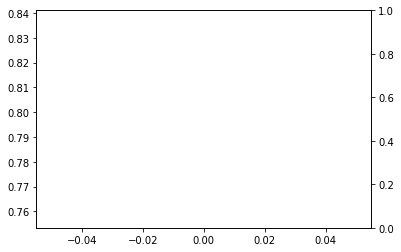

In [24]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()
    